In [1]:
import kagglehub , glob , os , random
from tensorflow.keras.preprocessing.image import load_img , img_to_array
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense , Input , Dropout , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report


# Download latest version
base_path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
base_path += "\\Garbage classification\\Garbage classification"
base_path

c:\Users\D\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\D\\.cache\\kagglehub\\datasets\\asdasdasasdas\\garbage-classification\\versions\\2\\Garbage classification\\Garbage classification'

In [2]:
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(len(img_list))


2527


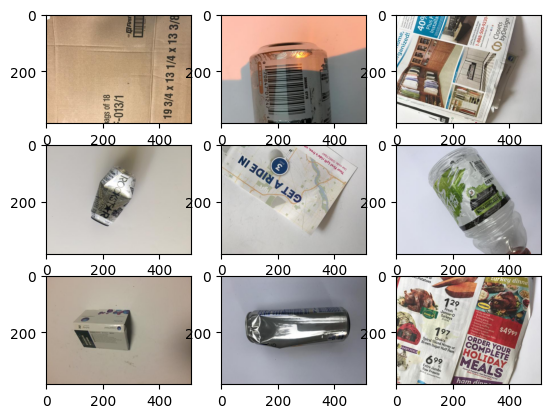

In [3]:
for i, img_path in enumerate(random.sample(img_list, 9)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(3, 3, i+1)
    plt.imshow(img.squeeze())

<Axes: >

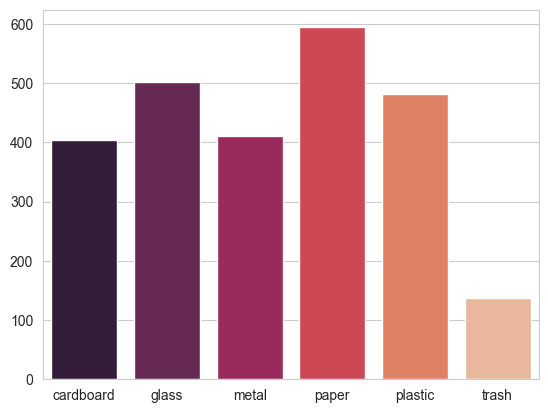

In [4]:
# plot class distribution by counting the number of images in each directory
count = {}
for dir in os.listdir(base_path):
    count[dir] = len(glob.glob(os.path.join(base_path, dir, '*.jpg')))

sns.set_style("whitegrid")
sns.barplot(x=count.keys(), y=count.values(), palette="rocket", hue=count.keys())

In [5]:
# load images
img_list = []
label_list = []
for dir in os.listdir(base_path):
    for img_path in glob.glob(os.path.join(base_path, dir, '*.jpg')):
        img = load_img(img_path)
        img = img_to_array(img, dtype=np.uint8)
        # downsample to 1/4 of the original size
        img = img[::2, ::2, :]
        img_list.append(img)
        label_list.append(dir)

X = np.array(img_list)
y = np.array(label_list)
print(X.shape , y.shape)

(2527, 192, 256, 3) (2527,)


In [6]:
def preprocess(X):
    X = X / 255.0
    return X

def one_hot_encode(y):
    label_dict = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4 , 'trash': 5}
    y = np.array([label_dict[label] for label in y])
    return np.eye(6)[y]

X = preprocess(X)
y = one_hot_encode(y)

In [7]:
# split data into train , test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
del X , y
print(f"train : {X_train.shape} , test : {X_test.shape} , validation : {X_val.shape}")

train : (1616, 192, 256, 3) , test : (506, 192, 256, 3) , validation : (405, 192, 256, 3)


In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    channel_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True
)

generator = datagen.flow(X_train, y_train, batch_size=64)

In [9]:
def model_cnn():
    model = Sequential()
    model.add(Input((192, 256, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    return model

model1 = model_cnn()
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 192, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 190, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 125, 96)    │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 62, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 60, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 28, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 12, 64)      │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,722 (1.65 MB)

 Trainable params: 432,716 (1.65 MB)

 Non-trainable params: 6 (24.00 B)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [11]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(generator, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


c:\Users\D\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2613 - loss: 1.6885 - val_accuracy: 0.1951 - val_loss: 1.8137
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3933 - loss: 1.5155 - val_accuracy: 0.2716 - val_loss: 1.6856
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4492 - loss: 1.4251 - val_accuracy: 0.3457 - val_loss: 1.6288
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4944 - loss: 1.3054 - val_accuracy: 0.4222 - val_loss: 1.5154
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5290 - loss: 1.2421 - val_accuracy: 0.4519 - val_loss: 1.4751
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5419 - loss: 1.1911 - val_accuracy: 0.4099 - val_loss: 1.4657
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5570 - loss: 1.1383 - val_accuracy: 0.4074 - val_loss: 1.4925
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5848 - loss: 1.0867 - val_accuracy: 0.4519 - val_loss: 1.4

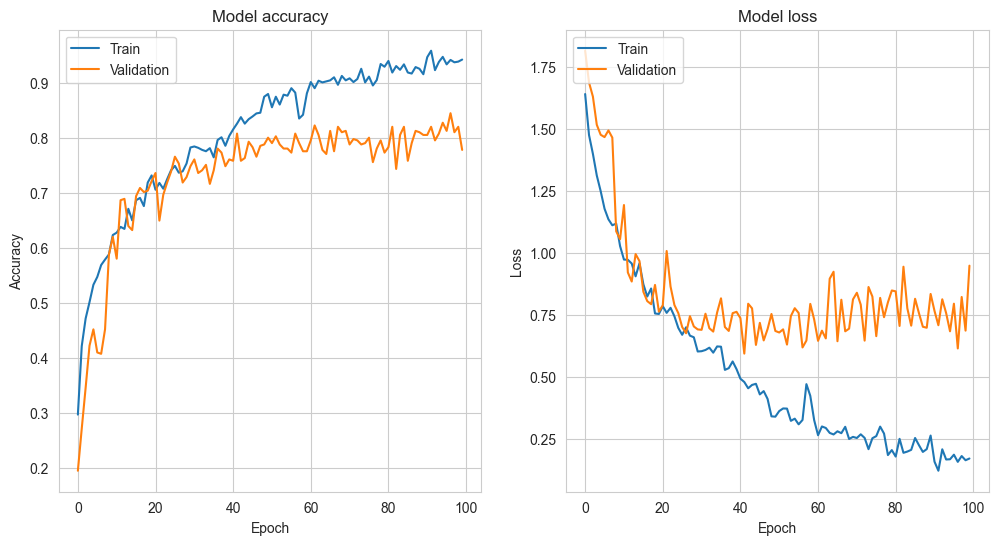

In [12]:
# plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [13]:
# print metrics on test set
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.75      0.80      0.78       107
           2       0.78      0.80      0.79        87
           3       0.77      0.89      0.83       118
           4       0.84      0.69      0.76        99
           5       0.67      0.42      0.51        24

    accuracy                           0.78       506
   macro avg       0.77      0.74      0.75       506
weighted avg       0.79      0.78      0.78       506



In [14]:
# save model
model1.save('model.h5')